In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch. optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
import pickle
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [2]:
cuda = 'cuda:1'

In [3]:
class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.l = len(self.data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
file = open('train_dataset_small.pkl', 'rb')
train_dataset = pickle.load(file)
file.close()
file = open('test_dataset_small.pkl', 'rb')
test_dataset = pickle.load(file)
file.close()

In [5]:
train_batch_size = 400
test_batch_size = 200
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

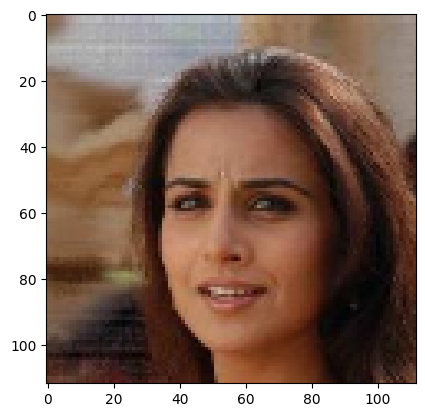

In [6]:
image = next(iter(train_loader))
plt.imshow(image[0].permute(1,2,0))
plt.show()

In [7]:
resnet = models.resnet18(weights='DEFAULT')
resnet_half = torch.nn.Sequential(*(list(resnet.children())[:7]))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_size = 12544
        self.encoder = nn.Sequential(
            *(list(resnet_half.children())),
            nn.ReLU(),
            nn.Flatten()
        )
        self.mu = nn.Sequential(
            nn.Linear(12544, self.latent_size)
        )
        self.log_var = nn.Sequential(
            nn.Linear(12544, self.latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([256, 7, 7])),
            nn.ConvTranspose2d(256, 256, (3,3),(2,2), padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, (3,3),(2,2)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(2,2)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(2,2)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, (4,4),(1,1), padding=1),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        x = self.reparameterize(mu, log_var)
        x = self.decoder(x)
        return x, mu, log_var

In [9]:
model = Net()
#model = nn.DataParallel(model, device_ids=[1,0])
model.to(cuda)

Net(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [10]:
def loss_f(output, target, mu, log_var):
    MSE = nn.MSELoss(reduction='mean')(output, target)
    KLD = 0.5 * torch.mean(mu**2 + torch.exp(log_var) -1 - log_var)
    return MSE + KLD, MSE, KLD

In [27]:
optimizer = optim.Adam(model.parameters(), lr = 0.00000067)
scheduler = ExponentialLR(optimizer, gamma=0.99)

train_loss_list = []
test_loss_list = []
train_MSE_list = []
test_MSE_list = []
train_KLD_list = []
test_KLD_list = []

for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    for x_train in train_loader:
        x_train = x_train.to(cuda)
        outputs, mu, log_var = model(x_train)
        loss, MSE, KLD = loss_f(outputs, x_train, mu, log_var)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
        for x_test in test_loader:
            x_test = x_test.to(cuda)
            outputs, mu, log_var = model(x_test)
            test_loss, test_MSE, test_KLD = loss_f(outputs, x_test, mu, log_var)
        print("Epoch:", epoch + 1, "Train_Loss:", loss.item(), "Test_Loss:", test_loss.item(), "Learning_Rate:", scheduler.optimizer.param_groups[0]['lr'])
        print("Train_MSE:", MSE.item(), "Train_KLD:", KLD.item(), "Test_MSE:", test_MSE.item(), "Test_KLD:", test_KLD.item())

        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
        train_MSE_list.append(MSE.item())
        test_MSE_list.append(test_MSE.item())
        train_KLD_list.append(KLD.item())
        test_KLD_list.append(test_KLD.item())

  5%|▌         | 10/200 [22:15<7:04:58, 134.20s/it]

Epoch: 10 Train_Loss: 0.02692544087767601 Test_Loss: 0.02855229750275612 Learning_Rate: 6.05935990255899e-07
Train_MSE: 0.01838807575404644 Train_KLD: 0.008537364192306995 Test_MSE: 0.021383438259363174 Test_KLD: 0.007168858777731657


 10%|█         | 20/200 [44:34<6:43:25, 134.47s/it]

Epoch: 20 Train_Loss: 0.028302637860178947 Test_Loss: 0.028564196079969406 Learning_Rate: 5.479976481901447e-07
Train_MSE: 0.02149779535830021 Train_KLD: 0.006804842036217451 Test_MSE: 0.02140105329453945 Test_KLD: 0.007163142319768667


 15%|█▌        | 30/200 [1:06:51<6:20:23, 134.25s/it]

Epoch: 30 Train_Loss: 0.02592569962143898 Test_Loss: 0.028474465012550354 Learning_Rate: 4.95599250170148e-07
Train_MSE: 0.018512291833758354 Train_KLD: 0.007413407322019339 Test_MSE: 0.0211071465164423 Test_KLD: 0.0073673175647854805


 20%|██        | 40/200 [1:29:11<5:58:35, 134.47s/it]

Epoch: 40 Train_Loss: 0.02880420908331871 Test_Loss: 0.028047285974025726 Learning_Rate: 4.48211078241686e-07
Train_MSE: 0.021331600844860077 Train_KLD: 0.007472608238458633 Test_MSE: 0.020723355934023857 Test_KLD: 0.007323930040001869


 25%|██▌       | 50/200 [1:51:27<5:35:18, 134.13s/it]

Epoch: 50 Train_Loss: 0.027076154947280884 Test_Loss: 0.028262659907341003 Learning_Rate: 4.053540649821495e-07
Train_MSE: 0.019923565909266472 Train_KLD: 0.0071525899693369865 Test_MSE: 0.020928170531988144 Test_KLD: 0.007334488909691572


 30%|███       | 60/200 [2:13:47<5:14:02, 134.59s/it]

Epoch: 60 Train_Loss: 0.02818753942847252 Test_Loss: 0.028302380815148354 Learning_Rate: 3.665949504018101e-07
Train_MSE: 0.020904039964079857 Train_KLD: 0.007283500395715237 Test_MSE: 0.021030046045780182 Test_KLD: 0.007272334769368172


 35%|███▌      | 70/200 [2:36:05<4:51:04, 134.34s/it]

Epoch: 70 Train_Loss: 0.026032529771327972 Test_Loss: 0.02852337434887886 Learning_Rate: 3.315419019321387e-07
Train_MSE: 0.01855393312871456 Train_KLD: 0.007478595711290836 Test_MSE: 0.0211785938590765 Test_KLD: 0.007344780955463648


 40%|████      | 80/200 [2:58:24<4:28:47, 134.40s/it]

Epoch: 80 Train_Loss: 0.026871521025896072 Test_Loss: 0.027822038158774376 Learning_Rate: 2.9984055322175313e-07
Train_MSE: 0.019508950412273407 Train_KLD: 0.007362569682300091 Test_MSE: 0.020415816456079483 Test_KLD: 0.007406221237033606


 45%|████▌     | 90/200 [3:20:43<4:06:21, 134.38s/it]

Epoch: 90 Train_Loss: 0.027320686727762222 Test_Loss: 0.027895530685782433 Learning_Rate: 2.71170421694477e-07
Train_MSE: 0.01909952238202095 Train_KLD: 0.008221165277063847 Test_MSE: 0.020494690164923668 Test_KLD: 0.007400840520858765


 50%|█████     | 100/200 [3:43:00<3:43:50, 134.30s/it]

Epoch: 100 Train_Loss: 0.028271431103348732 Test_Loss: 0.02771626226603985 Learning_Rate: 2.4524166865306363e-07
Train_MSE: 0.020725052803754807 Train_KLD: 0.007546377833932638 Test_MSE: 0.020307131111621857 Test_KLD: 0.007409131620079279


 55%|█████▍    | 109/200 [4:04:40<3:24:16, 134.69s/it]


KeyboardInterrupt: 

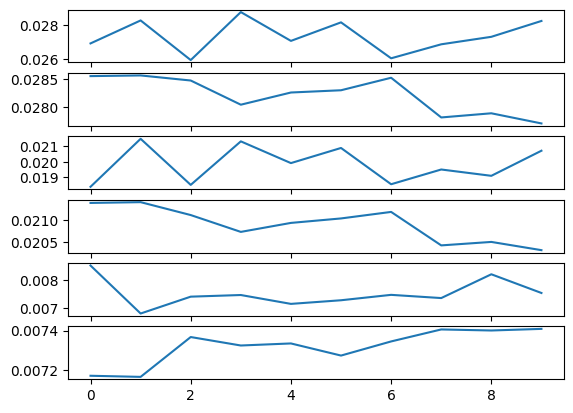

In [28]:
fig, ax = plt.subplots(6)
ax[0].plot(train_loss_list)
ax[1].plot(test_loss_list)
ax[2].plot(train_MSE_list)
ax[3].plot(test_MSE_list)
ax[4].plot(train_KLD_list)
ax[5].plot(test_KLD_list)

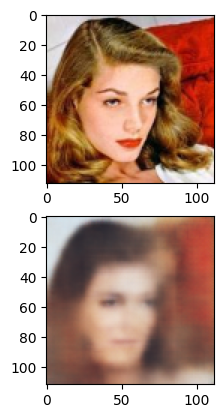

In [35]:
fig, ax = plt.subplots(2)
torch.no_grad()
x_train = next(iter(train_loader))
x_train = x_train.to(cuda)
outputs, mu, log_var = model(x_train)
outputs = outputs.cpu().detach()
ax[0].imshow(x_train.cpu()[0].permute((1,2,0)))
ax[1].imshow(outputs[0].permute(1,2,0)) 

In [ ]:
import pickle
with open('checkpoint400.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)